In [ ]:
# Import packages
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
def initialize_parameters(layers_dims):
    np.random.seed(1)               
    parameters = {}
    L = len(layers_dims)            

    for l in range(1, L):           
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 0.01
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        assert parameters["W" + str(l)].shape == (
            layers_dims[l], layers_dims[l - 1])
        assert parameters["b" + str(l)].shape == (layers_dims[l], 1)
    
    return parameters

In [ ]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z


def tanh(Z):
    A = np.tanh(Z)
    return A, Z


def relu(Z):
    A = np.maximum(0, Z)
    return A, Z


def leaky_relu(Z):
    A = np.maximum(0.1 * Z, Z)
    return A, Z

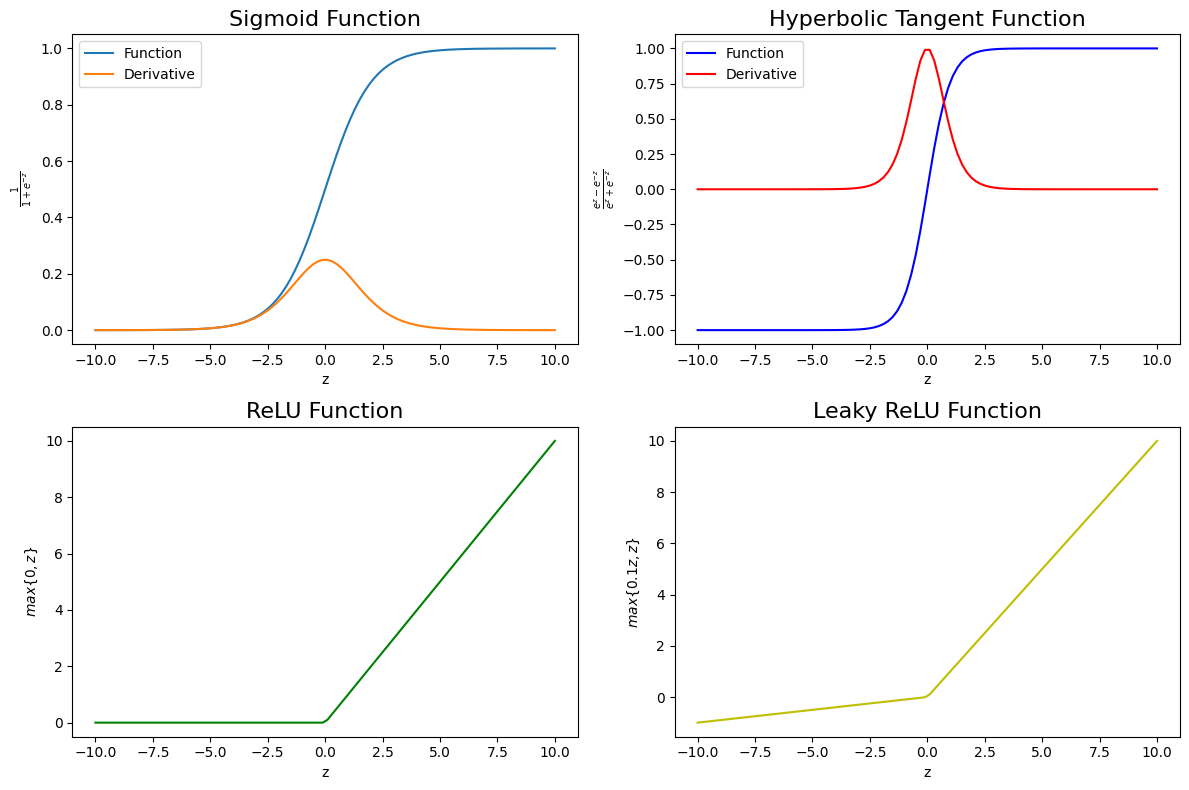

In [ ]:
# Plot the 4 activation functions
z = np.linspace(-10, 10, 100)

# Computes post-activation outputs
A_sigmoid, z = sigmoid(z)
A_tanh, z = tanh(z)
A_relu, z = relu(z)
A_leaky_relu, z = leaky_relu(z)

# Plot sigmoid
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(z, A_sigmoid, label="Function")
plt.plot(z, A_sigmoid * (1 - A_sigmoid), label = "Derivative")
plt.legend(loc="upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{1}{1 + e^{-z}}$")
plt.title("Sigmoid Function", fontsize=16)
# Plot tanh
plt.subplot(2, 2, 2)
plt.plot(z, A_tanh, 'b', label = "Function")
plt.plot(z, 1 - np.square(A_tanh), 'r',label="Derivative")
plt.legend(loc="upper left")
plt.xlabel("z")
plt.ylabel(r"$\frac{e^z - e^{-z}}{e^z + e^{-z}}$")
plt.title("Hyperbolic Tangent Function", fontsize=16)
# plot relu
plt.subplot(2, 2, 3)
plt.plot(z, A_relu, 'g')
plt.xlabel("z")
plt.ylabel(r"$max\{0, z\}$")
plt.title("ReLU Function", fontsize=16)
# plot leaky relu
plt.subplot(2, 2, 4)
plt.plot(z, A_leaky_relu, 'y')
plt.xlabel("z")
plt.ylabel(r"$max\{0.1z, z\}$")
plt.title("Leaky ReLU Function", fontsize=16)
plt.tight_layout();

In [ ]:
# Define helper functions that will be used in L-model forward prop
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache


def linear_activation_forward(A_prev, W, b, activation_fn):
    assert activation_fn == "sigmoid" or activation_fn == "tanh" or \
        activation_fn == "relu"

    if activation_fn == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation_fn == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    elif activation_fn == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert A.shape == (W.shape[0], A_prev.shape[1])

    cache = (linear_cache, activation_cache)
    return A, cache


def L_model_forward(X, parameters, hidden_layers_activation_fn="relu"):
    A = X                           
    caches = []                     
    L = len(parameters) // 2        

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(
            A_prev, parameters["W" + str(l)], parameters["b" + str(l)],
            activation_fn=hidden_layers_activation_fn)
        caches.append(cache)

    AL, cache = linear_activation_forward(
        A, parameters["W" + str(L)], parameters["b" + str(L)],
        activation_fn="sigmoid")
    caches.append(cache)

    assert AL.shape == (1, X.shape[1])
    return AL, caches

In [ ]:
# Compute cross-entropy cost
def compute_cost(AL, y):
    m = y.shape[1]              
    cost = - (1 / m) * np.sum(
        np.multiply(y, np.log(AL)) + np.multiply(1 - y, np.log(1 - AL)))
    return cost

In [ ]:
def sigmoid_gradient(dA, Z):
    A, Z = sigmoid(Z)
    dZ = dA * A * (1 - A)

    return dZ


def tanh_gradient(dA, Z):
    A, Z = tanh(Z)
    dZ = dA * (1 - np.square(A))

    return dZ


def relu_gradient(dA, Z):
    A, Z = relu(Z)
    dZ = np.multiply(dA, np.int64(A > 0))

    return dZ


# define helper functions that will be used in L-model back-prop
def linear_backword(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation_fn):
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, y, caches, hidden_layers_activation_fn="relu"):
    y = y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(
            dAL, caches[L - 1], "sigmoid")

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads[
            "db" + str(l)] = linear_activation_backward(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn)

    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters[
            "W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters[
            "b" + str(l)] - learning_rate * grads["db" + str(l)]
    return parameters

Original dimensions:
--------------------
Training: (209, 64, 64, 3), (209,)
Test: (50, 64, 64, 3), (50,)

New dimensions:
---------------
Training: (12288, 209), (1, 209)
Test: (12288, 50), (1, 50)


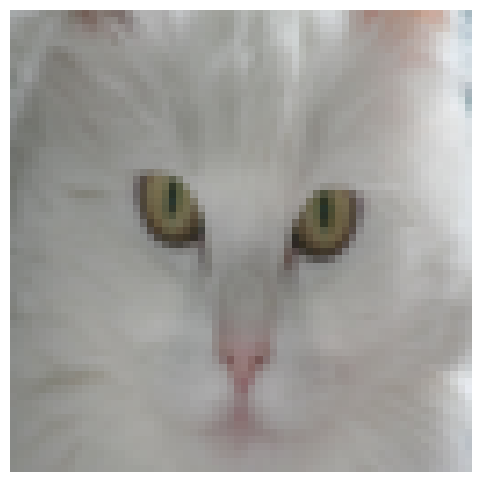

In [ ]:
# Import training dataset
train_dataset = h5py.File("/content/train_catvnoncat.h5")
X_train = np.array(train_dataset["train_set_x"])
y_train = np.array(train_dataset["train_set_y"])

test_dataset = h5py.File("/content/test_catvnoncat.h5")
X_test = np.array(test_dataset["test_set_x"])
y_test = np.array(test_dataset["test_set_y"])

# print the shape of input data and label vector
print(f"""Original dimensions:\n{20 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

# plot cat image
plt.figure(figsize=(6, 6))
plt.imshow(X_train[50])
plt.axis("off");

# Transform input data and label vector
X_train = X_train.reshape(209, -1).T
y_train = y_train.reshape(-1, 209)

X_test = X_test.reshape(50, -1).T
y_test = y_test.reshape(-1, 50)

# standardize the data
X_train = X_train / 255
X_test = X_test / 255

print(f"""\nNew dimensions:\n{15 * '-'}\nTraining: {X_train.shape}, {y_train.shape}
Test: {X_test.shape}, {y_test.shape}""")

In [ ]:
# Define the multi-layer model using all the helper functions we wrote before
def L_layer_model(
        X, y, layers_dims, learning_rate=0.01, num_iterations=3000,
        print_cost=True, hidden_layers_activation_fn="relu"):
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn)

        # compute cost to plot it
        cost = compute_cost(AL, y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print(f"The cost after {i + 1} iterations is: {cost:.4f}")

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(10, 6))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Loss")
    plt.title(f"Loss curve for the learning rate = {learning_rate}")

    return parameters


def accuracy(X, parameters, y, activation_fn="relu"):
    probs, caches = L_model_forward(X, parameters, activation_fn)
    labels = (probs >= 0.5) * 1
    accuracy = np.mean(labels == y) * 100
    return f"The accuracy rate is: {accuracy:.2f}%."

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6439
The cost after 900 iterations is: 0.6439
The cost after 1000 iterations is: 0.6439
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6438
The cost after 1400 iterations is: 0.6438
The cost after 1500 iterations is: 0.6437
The cost after 1600 iterations is: 0.6434
The cost after 1700 iterations is: 0.6429
The cost after 1800 iterations is: 0.6413
The cost after 1900 iterations is: 0.6361
The cost after 2000 iterations is: 0.6124
The cost after 2100 iterations is: 0.5112
The cost after 2200 iterations is: 0.5625
The cost after 2300 iterations is: 0.4061
The cost after 2400 iterations is: 0.3840
T

'The accuracy rate is: 68.00%.'

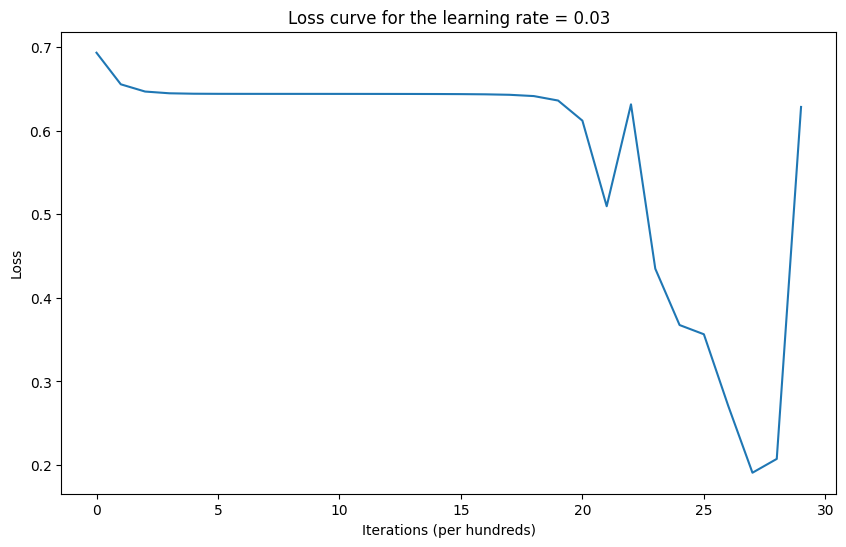

In [ ]:
# Setting layers dims
layers_dims = [X_train.shape[0], 5, 5, 1]
# NN with tanh activation fn
parameters_tanh = L_layer_model( X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=5000, hidden_layers_activation_fn="tanh")
# Print the accuracy
accuracy(X_test, parameters_tanh, y_test, activation_fn="tanh")

The cost after 100 iterations is: 0.6556
The cost after 200 iterations is: 0.6468
The cost after 300 iterations is: 0.6447
The cost after 400 iterations is: 0.6441
The cost after 500 iterations is: 0.6440
The cost after 600 iterations is: 0.6440
The cost after 700 iterations is: 0.6440
The cost after 800 iterations is: 0.6440
The cost after 900 iterations is: 0.6440
The cost after 1000 iterations is: 0.6440
The cost after 1100 iterations is: 0.6439
The cost after 1200 iterations is: 0.6439
The cost after 1300 iterations is: 0.6439
The cost after 1400 iterations is: 0.6439
The cost after 1500 iterations is: 0.6439
The cost after 1600 iterations is: 0.6439
The cost after 1700 iterations is: 0.6438
The cost after 1800 iterations is: 0.6437
The cost after 1900 iterations is: 0.6435
The cost after 2000 iterations is: 0.6432
The cost after 2100 iterations is: 0.6423
The cost after 2200 iterations is: 0.6395
The cost after 2300 iterations is: 0.6259
The cost after 2400 iterations is: 0.5408
T

'The accuracy rate is: 42.00%.'

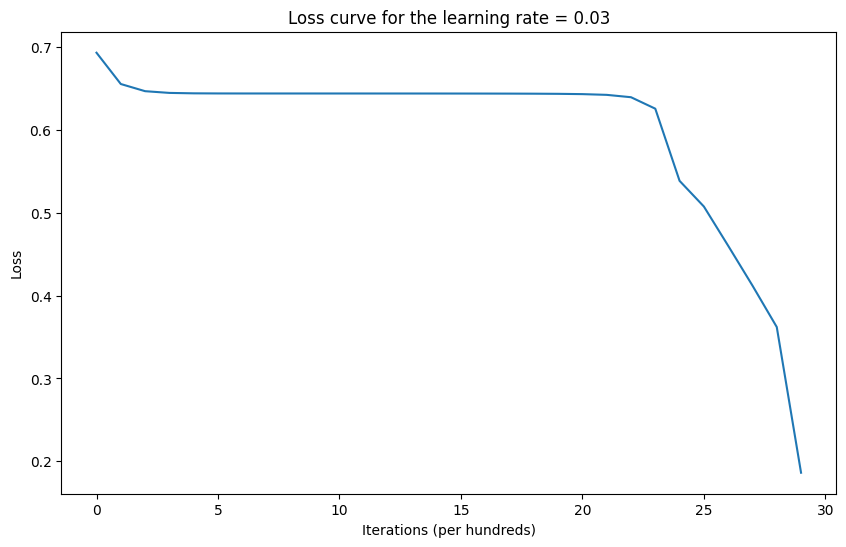

In [ ]:
# NN with relu activation fn
parameters_relu = L_layer_model( X_train, y_train, layers_dims, learning_rate=0.03, num_iterations=3000, hidden_layers_activation_fn="relu")
# Print the accuracy
accuracy(X_test, parameters_relu, y_test, activation_fn="relu")